In [1]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
import time
import warnings
warnings. simplefilter(action='ignore', category=FutureWarning)

adding columns names to dataset

In [2]:
df = pd.read_csv("Grocery_and_Gourmet_Food.csv", names=["productId", "userId", "rating", "timestamp"])  
df.head()

,productId,userId,rating,timestamp
0,1888861614,ALP49FBWT4I7V,5.0,1370304000
1,1888861614,A1KPIZOCLB9FZ8,4.0,1400803200
2,1888861614,A2W0FA06IYAYQE,4.0,1399593600
3,1888861614,A2PTZTCH2QUYBC,5.0,1397952000
4,1888861614,A2VNHGJ59N4Z90,4.0,1397606400


Shape of the data

In [3]:
rows_count, columns_count = df.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 5074160
Total Number of columns : 4


Data type of each attribute

In [4]:
df.dtypes

productId     object
userId        object
rating       float64
timestamp      int64
dtype: object

By displaying the datatypes of each variable we can see that rating and timing are numerical datatypes while productId and userId are objects

In [5]:
unique_userId = df['userId'].nunique()
unique_productId = df['productId'].nunique()
print('Total number of unique users: ', unique_userId)
print('Total number of unique products: ', unique_productId)

Total number of unique users:  2695974
Total number of unique products:  283507


To check for missing values

In [6]:
df.isnull().sum()

productId    0
userId       0
rating       0
timestamp    0
dtype: int64

In [7]:
df.isna().any()

productId    False
userId       False
rating       False
timestamp    False
dtype: bool

from all the above outputs, we can see that this dataset has no missing values

Characteristics of the numerical attributes

In [8]:
df_transpose = df.describe().T
df_transpose

,count,mean,std,min,25%,50%,75%,max
rating,5074160.0,4.314708e+00,1.249303e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,5074160.0,1.446592e+09,6.227839e+07,961372800.0,1.416096e+09,1.456790e+09,1.491782e+09,1.538870e+09


The distribution is negatively skewed - the mean of rating is less than median
Mean of timestamp is almost near the median which stats the distribution is symmetric.

In [9]:
df_transpose[['min', '25%', '50%', '75%', 'max']]

,min,25%,50%,75%,max
rating,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,961372800.0,1.416096e+09,1.456790e+09,1.491782e+09,1.538870e+09


Check for outliers

<AxesSubplot:>

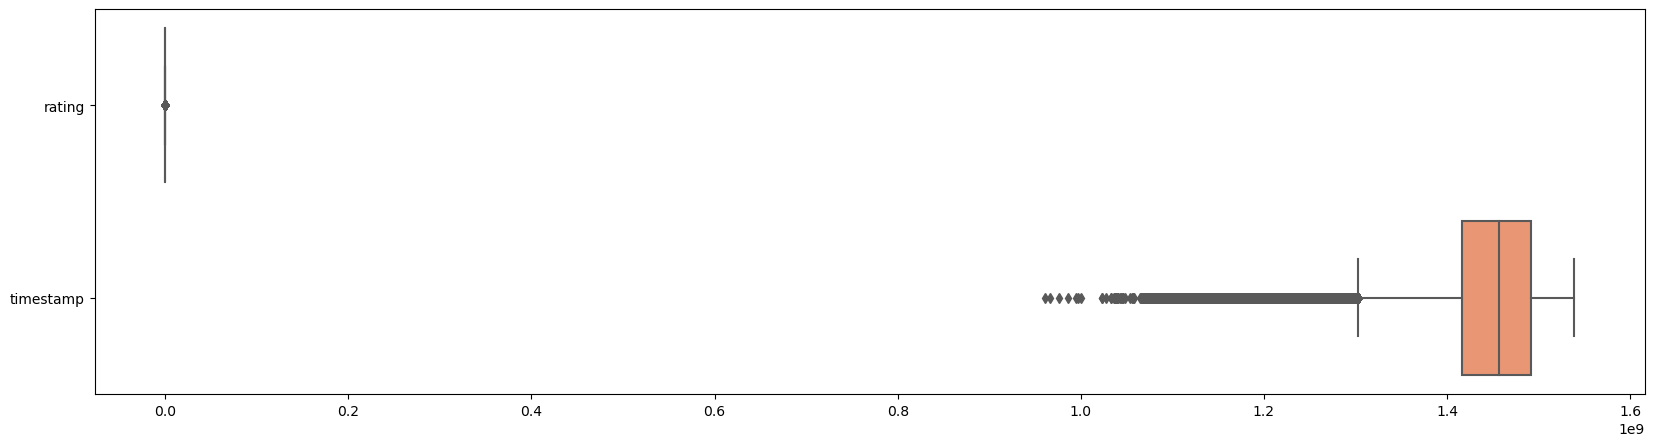

In [10]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, orient='h', palette='Set2', dodge=False)

 Checking the ratio of all the ratings

In [11]:
df['rating'].value_counts()

5.0    3573998
4.0     553201
1.0     405330
3.0     322134
2.0     219497
Name: rating, dtype: int64

In [12]:
rating_counts = pd.DataFrame(df['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5.0,3573998
1,4.0,553201
2,1.0,405330
3,3.0,322134
4,2.0,219497


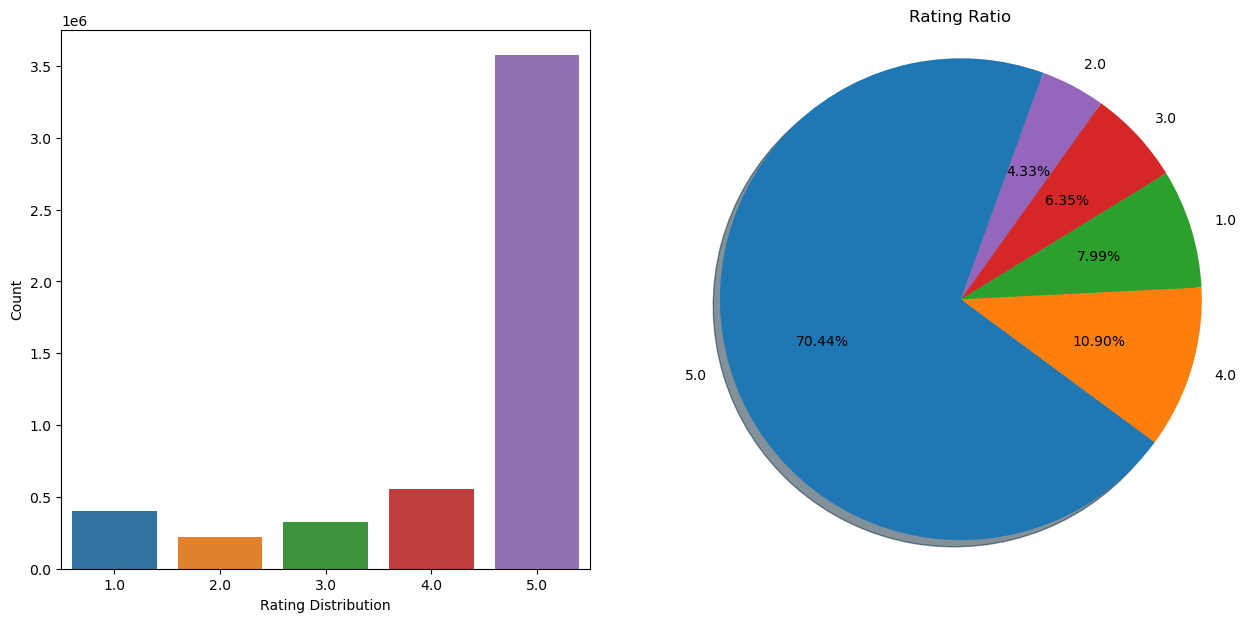

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(x=df['rating'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax2.pie(rating_counts["Ratings"], labels=rating_counts.Labels, autopct='%1.2f%%', shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.show()

 around 70% of data have 5 ratings followed by 4. Least number of people have given 2 ratings. Again we can see that most of the products are liked by the customers.

Correlation Matrix

In [14]:
df.corr()

,rating,timestamp
rating,1.000000,-0.008704
timestamp,-0.008704,1.000000


<AxesSubplot:title={'center':'Correlation of Attributes'}>

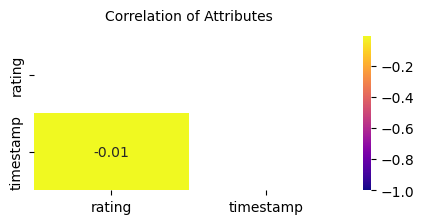

In [15]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,2))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(df.corr(),vmin=-1, cmap='plasma', annot=True,  mask=mask, fmt='.2f')

timestamp and ratings are barely correlated and that's negatively correlation

Dropping timestamp

In [16]:
df = df.drop(['timestamp'], axis=1)

In [17]:
df1=df.copy()

In [18]:
df1.head()

,productId,userId,rating
0,1888861614,ALP49FBWT4I7V,5.0
1,1888861614,A1KPIZOCLB9FZ8,4.0
2,1888861614,A2W0FA06IYAYQE,4.0
3,1888861614,A2PTZTCH2QUYBC,5.0
4,1888861614,A2VNHGJ59N4Z90,4.0


picking users that have given a higher number of ratings to make dataset denser

In [19]:
users_counts = df1['userId'].value_counts().rename('users_counts')
users_data = df1.merge(users_counts.to_frame(), left_on='userId', right_index=True)
df_subset = users_data[users_data.users_counts >= 50]
df_subset.head()

,productId,userId,rating,users_counts
115,4639725043,ALOGZDSPWZI72,4.0,98
19126,B0000EYK3E,ALOGZDSPWZI72,3.0,98
28542,B00014JNI0,ALOGZDSPWZI72,5.0,98
37479,B00016LZT8,ALOGZDSPWZI72,5.0,98
55749,B0001M0Z7A,ALOGZDSPWZI72,5.0,98


Also taking a subset of products that have 10+ ratings given to fix the cold start problem

In [20]:
product_counts = df_subset['productId'].value_counts().rename('product_counts')
product_data = df_subset.merge(product_counts.to_frame(), left_on='productId', right_index=True)
product_data = product_data[product_data.product_counts >= 10]
product_data.head()

,productId,userId,rating,users_counts,product_counts
28542,B00014JNI0,ALOGZDSPWZI72,5.0,98,29
30911,B00014JNI0,A2EZTM9WY5B5IL,5.0,81,29
29403,B00014JNI0,A3SXKZ1Y3SGW3Q,5.0,51,29
30579,B00014JNI0,A3GUNEINK3GRDV,5.0,59,29
28994,B00014JNI0,A18PFXJ4QPTSX3,5.0,55,29


In [21]:
df2=product_data.copy()

In [22]:
df3 = df2.drop(['users_counts', 'product_counts'], axis=1)
df3.head()

,productId,userId,rating
28542,B00014JNI0,ALOGZDSPWZI72,5.0
30911,B00014JNI0,A2EZTM9WY5B5IL,5.0
29403,B00014JNI0,A3SXKZ1Y3SGW3Q,5.0
30579,B00014JNI0,A3GUNEINK3GRDV,5.0
28994,B00014JNI0,A18PFXJ4QPTSX3,5.0


Splitting data into 70/30 train and test data

In [23]:
k=5 #for top 5 recommendations
reader = Reader(rating_scale=(1, 5)) #for suprise module

In [24]:
surprise_data = Dataset.load_from_df(df3[['userId', 'productId', 'rating']], reader)

In [25]:
train, test = train_test_split(surprise_data, test_size=.30, random_state=7)

# Collaborative Filtering Models

In [26]:
cv_results = []  # to store cross validation result 

# Matrix Factorization Based Algorithms

Grid Search: to find out the best hyper parameters for SVD and SVDpp Algorithm.

In [27]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

In [28]:
svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

In [29]:
svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

In [30]:
# best RMSE score
print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

0.8748163173041213
0.8796707462977743


In [31]:
# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


### SVD

In [32]:
svd_model = SVD(n_epochs=25, lr_all=0.01, reg_all=0.4)

In [33]:
# Training the algorithm on the trainset
svd_model.fit(train)

In [34]:
# Predicting for test set
predictions_svd = svd_model.test(test)

In [35]:
# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

svd_df = pd.DataFrame.from_dict(svd_cv)
svd_describe = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_describe['test_rmse']['mean'], svd_describe['test_mae']['mean'], 
                           svd_describe['fit_time']['mean'], svd_describe['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8787  0.8818  0.8773  0.8603  0.8795  0.8755  0.0078  
MAE (testset)     0.6200  0.6165  0.6155  0.6078  0.6141  0.6148  0.0040  
Fit time          3.27    2.79    3.01    1.95    3.49    2.90    0.53    
Test time         0.41    0.40    0.34    0.40    0.73    0.46    0.14    


In [36]:
#RMSE - Model Evaluation
accuracy.rmse(predictions_svd, verbose=True)

RMSE: 0.8679


0.8678595041055556

In [37]:
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875508,0.614768,2.903672,0.456893


RMSE from the test set and the cross validation test are almost the same, therefore the model is performing well

### SVD++

In [38]:
svdpp_model = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)

In [39]:
# Training the algorithm on the trainset
svdpp_model.fit(train)

In [40]:
# Predicting for test set
predictions_svdpp = svdpp_model.test(test)

In [41]:
# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'], 
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8745  0.8845  0.8779  0.8710  0.8823  0.8780  0.0049  
MAE (testset)     0.6123  0.6195  0.6186  0.6142  0.6191  0.6167  0.0029  
Fit time          16.52   15.60   16.90   8.63    9.15    13.36   3.68    
Test time         2.62    2.74    1.47    1.36    1.24    1.88    0.66    


In [42]:
cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)

In [43]:
#RMSE - model evaluation
accuracy.rmse(predictions_svdpp, verbose=True)

RMSE: 0.8721


0.8721472109974966

In [44]:
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875508,0.614768,2.903672,0.456893
1,SVDpp,0.878040,0.616748,13.359809,1.884406


# k-NN Based Algorithms 

grid-search

In [45]:
knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'], 'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

In [46]:
knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

In [47]:
knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

In [48]:
# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

0.9298845202313816
0.8793171554436803
0.8956024431091952


In [49]:
# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'msd', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'msd', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 15, 'sim_options': {'name': 'msd', 'user_based': True}}


### KNN Basic

In [50]:
knnBasic_model = KNNBasic(k=15, sim_options={'name': 'msd', 'user_based': False})

# Training the algorithm on the trainset
knnBasic_model.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [51]:
# Predicting for test set
prediction_knnBasic = knnBasic_model.test(test)

In [52]:
# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8638  0.9131  0.9215  0.9151  0.9114  0.9050  0.0209  
MAE (testset)     0.5229  0.5522  0.5576  0.5516  0.5546  0.5478  0.0126  
Fit time          0.13    0.13    0.14    0.14    0.13    0.13    0.00    
Test time         0.63    0.63    0.59    0.55    0.59    0.60    0.03    


In [53]:
# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'], 
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

In [54]:
cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

In [55]:
# get RMSE - model evaluation
accuracy.rmse(prediction_knnBasic, verbose=True)

RMSE: 0.9195


0.919463058273931

In [56]:
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875508,0.614768,2.903672,0.456893
1,SVDpp,0.878040,0.616748,13.359809,1.884406
2,KNNBasic,0.904970,0.547772,0.134566,0.598898


### KNN with zscore

In [57]:
# Creating Model using best parameters
knnZscore_model = KNNWithZScore(k=15, sim_options={'name': 'msd', 'user_based': False})

# Training the algorithm on the trainset
knnZscore_model.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [58]:
# Predicting for testset
prediction_knnZscore = knnZscore_model.test(test)

In [59]:
# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8949  0.9327  0.9081  0.9120  0.9166  0.9129  0.0123  
MAE (testset)     0.5578  0.5812  0.5768  0.5786  0.5774  0.5744  0.0084  
Fit time          0.26    0.30    0.28    0.29    0.29    0.28    0.01    
Test time         0.70    0.68    0.66    0.72    0.65    0.68    0.02    


In [60]:
# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'], 
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

In [61]:
cv_results = cv_results.append(knnZscore_cv_results, ignore_index=True)

In [62]:
# get RMSE - model evaluation
accuracy.rmse(prediction_knnZscore, verbose=True)

RMSE: 0.9238


0.9237594741597047

In [63]:
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875508,0.614768,2.903672,0.456893
1,SVDpp,0.878040,0.616748,13.359809,1.884406
2,KNNBasic,0.904970,0.547772,0.134566,0.598898
3,KNNWithZScore,0.912868,0.574370,0.284607,0.682601


### KNN with mean - user-user

In [64]:
knnMeansUU_model = KNNWithMeans(k=15, sim_options={'name': 'msd', 'user_based': True})

# Training the algorithm on the trainset
knnMeansUU_model.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [65]:
# Predicting for testset
prediction_knnMeansUU = knnMeansUU_model.test(test)

In [66]:
# Evaluating RMSE, MAE of algorithm KNNWithMeans User-User on 5 split(s)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8839  0.8665  0.8986  0.8595  0.8973  0.8812  0.0158  
MAE (testset)     0.5682  0.5550  0.5695  0.5569  0.5715  0.5642  0.0069  
Fit time          0.16    0.15    0.15    0.17    0.15    0.15    0.01    
Test time         0.61    0.60    0.76    0.59    0.58    0.63    0.07    


In [67]:
# Storing Crossvalidation Results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'], 
                           knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

In [68]:
cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index=True)

In [69]:
# get RMSE - model evaluation
accuracy.rmse(prediction_knnMeansUU, verbose=True)

RMSE: 0.8856


0.8856344788719053

In [70]:
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875508,0.614768,2.903672,0.456893
1,SVDpp,0.878040,0.616748,13.359809,1.884406
2,KNNBasic,0.904970,0.547772,0.134566,0.598898
3,KNNWithZScore,0.912868,0.574370,0.284607,0.682601
4,KNNWithMeans User-User,0.881156,0.564224,0.153445,0.629413


### KNN with mean - item-item

In [71]:
# Creating Model using best parameters
knnMeansII_model = KNNWithMeans(k=15, sim_options={'name': 'msd', 'user_based': False})

# Training the algorithm on the trainset
knnMeansII_model.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [72]:
# Predicting for testset
prediction_knnMeansII = knnMeansII_model.test(test)

In [73]:
# Evaluating RMSE, MAE of algorithm KNNWithMeans Item-Item on 5 split(s)
knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8952  0.9053  0.8827  0.9062  0.9102  0.8999  0.0099  
MAE (testset)     0.5694  0.5765  0.5623  0.5798  0.5869  0.5750  0.0085  
Fit time          0.17    0.16    0.20    0.18    0.18    0.18    0.01    
Test time         0.60    0.65    0.65    0.60    0.60    0.62    0.02    


In [74]:
# Storing Crossvalidation Results in dataframe
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()
knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'], knnMeansII_described['test_mae']['mean'], 
                           knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

In [75]:
cv_results = cv_results.append(knnMeansII_cv_results, ignore_index=True)

In [76]:
# get RMSE - Model Evaluation
accuracy.rmse(prediction_knnMeansII, verbose=True)

RMSE: 0.9062


0.9061957712385181

In [77]:
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875508,0.614768,2.903672,0.456893
1,SVDpp,0.878040,0.616748,13.359809,1.884406
2,KNNBasic,0.904970,0.547772,0.134566,0.598898
3,KNNWithZScore,0.912868,0.574370,0.284607,0.682601
4,KNNWithMeans User-User,0.881156,0.564224,0.153445,0.629413
5,KNNWithMeans Item-Item,0.899931,0.574981,0.177519,0.620676


Comparing the rmse and mae values for all the models

In [78]:
x_algo = ['KNN Basic', 'KNNWithMeans-User-User', 'KNNWithMeans-Item-Item', 'KNN ZScore', 'SVD', 'SVDpp']
all_algos_cv = [knnBasic_cv, knnMeansUU_cv, knnMeansII_cv, knnZscore_cv, svd_cv, svdpp_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv  = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

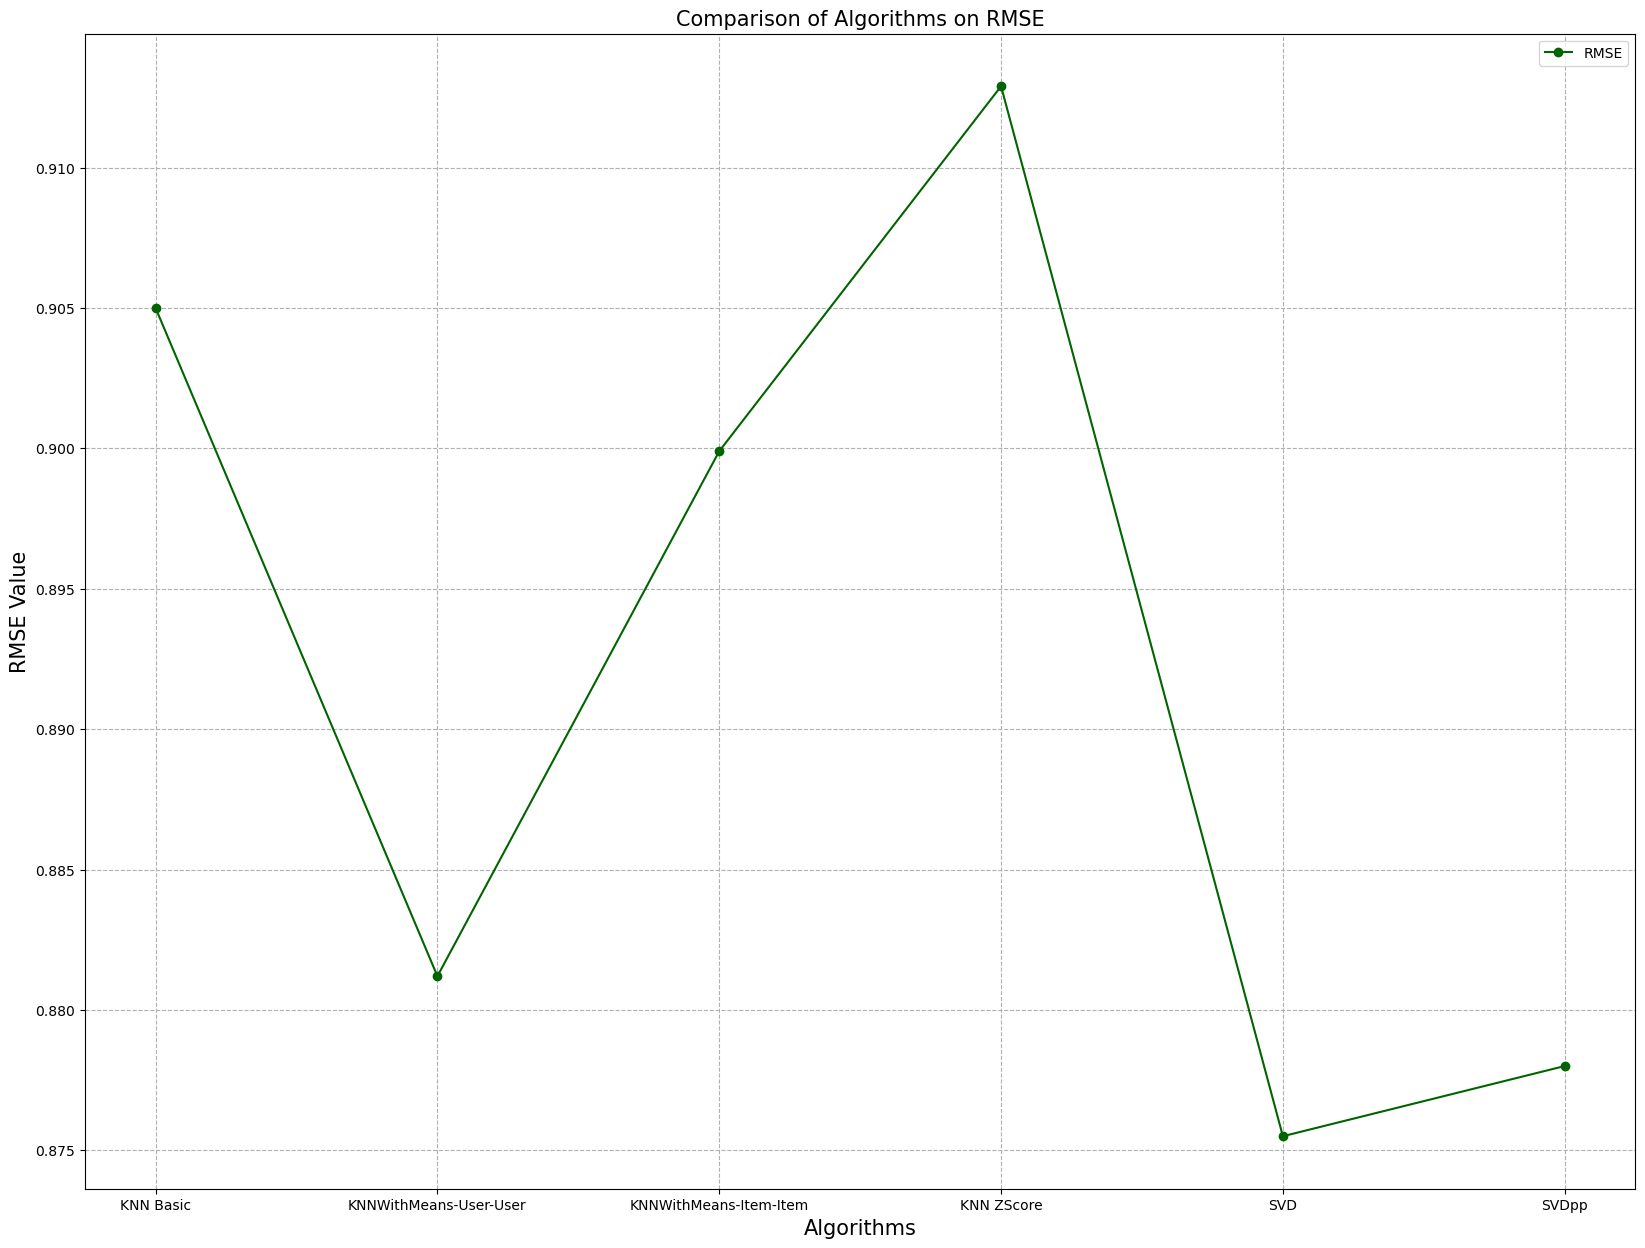

In [79]:
plt.figure(figsize=(20,15))

plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

In [80]:
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.875508,0.614768,2.903672,0.456893
1,SVDpp,0.878040,0.616748,13.359809,1.884406
2,KNNBasic,0.904970,0.547772,0.134566,0.598898
3,KNNWithZScore,0.912868,0.574370,0.284607,0.682601
4,KNNWithMeans User-User,0.881156,0.564224,0.153445,0.629413
5,KNNWithMeans Item-Item,0.899931,0.574981,0.177519,0.620676


From above algorithm comparisons plots we can infer the following:

RMSE : SVD gives us the best RMSE value with parameters {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
       SVD++ has almost a similar RMSE value

MAE : Knn Basic has the best MAE value.
    
Svd has the best RMSE in Matrix Factorization Based Algorithms.
KNNwithMeans has the best RMSE in Collaborative Filtering Algorithms

On comparing SVD and SVD++ then can notice that RMSE and MAE value of SVD is slightly lower than SVD++ and the Fit Time and Test Time taken by SVD is significantly lesser than SVD++. 
Hence we'll use SVD got get top-k recommendations

Using SVD to get the top 5 new products for each user

In [81]:
top_n = defaultdict(list)
def get_top_n(predictions, n=k):
    # map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n

defaultdict(list,
            {'A1ZPY91VE3IDN1': [('B001GCVLVI', 4.863646557748024),
              ('B0058AN1N0', 4.742365443933661),
              ('B000EUD6AM', 4.73018453725326),
              ('B0017U48KK', 4.7019252030188685),
              ('B0017U48KK', 4.7019252030188685)],
             'A3FS2KNCKXYZYN': [('B003Q4TS78', 4.708658011071384),
              ('B00ZCQK0MU', 4.669519877367345),
              ('B000WGB3OY', 4.627121772611507),
              ('B001E55ZQO', 4.4038716211529225)],
             'AVJV35095JH71': [('B00Y8HZS1W', 4.569329240739378),
              ('B0017WG1J4', 4.542672354892545),
              ('B00FW9Y1CW', 4.489593307491883),
              ('B000GZSDZI', 4.357558612526905),
              ('B00XA8XWGS', 4.300402920712805)],
             'A25HG1C9CC8MXD': [('B00FQGP20Q', 4.87233472830441),
              ('B00338BVQ8', 4.828178298564371),
              ('B004YPJKBC', 4.743225492603455),
              ('B001N2GRX8', 4.722894013629607),
              ('B000E1HUV

The model recommends top 5 products to each user. 
There are some cases where it recommends less than 5 products. It happens because model is not able to find appropriate number of neighbours.

 Precision and recall at k=5

In [82]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # mapping the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


kf = KFold(n_splits=5)
svd_model = SVD(n_epochs=25, lr_all=0.01, reg_all=0.4)
precs = []
recalls = []

for trainset, testset in kf.split(surprise_data):
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print('Precision : ', sum(prec for prec in precisions.values()) / len(precisions))
    print('recalls : ',sum(rec for rec in recalls.values()) / len(recalls))

Precision :  0.8762603795966772
recalls :  0.862183958704777
Precision :  0.8794508414526124
recalls :  0.8613721130028472
Precision :  0.8797481481481467
recalls :  0.8606958422201605
Precision :  0.8843058049072403
recalls :  0.8582212311174311
Precision :  0.889391199517781
recalls :  0.8633364696003956


#assumptions made while turning the numerical problem to binary (relevant/not relevant items):
rating > 3.5 = relevant; rating <= 3.5 = irrelevant

Precision at 5 in a top-5 recommendation problem is around 87%. This means that 87% of the recommendation are relevant to the users.
Recall at 5 in a top-5 recommendation problem is around 86%. This means that 86% of the total number of the relevant products appear in the top-k result.